In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-10-17 16:05:53.817905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#Constraints
imageDir = '/Users/sunilrosen/Desktop/archive/tom_and_jerry/tom_and_jerry'

batch_size = 64
img_height = 160
img_width = 160

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=imageDir,
    label_mode='int',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    validation_split=0.2,
    subset='training',
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=imageDir,
    label_mode='int',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Display class names
print(train_ds.class_names)
print(val_ds.class_names)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.
['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']


2024-10-17 16:09:38.558202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4383]
	 [[{{node Placeholder/_4}}]]
2024-10-17 16:09:38.559901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4383]
	 [[{{node Placeholder/_0}}]]


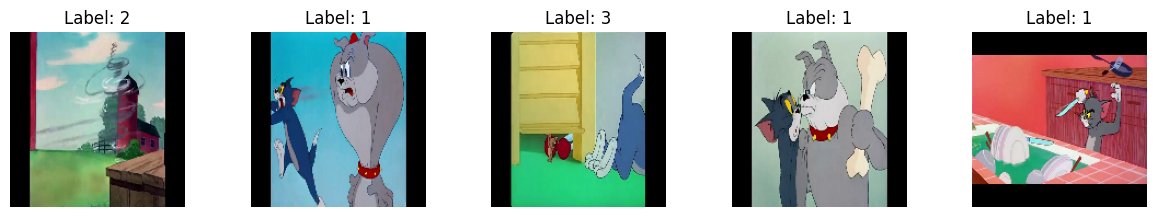

In [8]:
plt.figure(figsize=(15, 5))
for i, (images, labels) in enumerate(train_ds.take(1)):
    for j in range(5):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

x = MaxPooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Flatten()(x)  
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,  
                               restore_best_weights=True)  

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=3, 
                    callbacks=[early_stopping])


Epoch 1/3


2024-10-17 16:09:46.121935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4383]
	 [[{{node Placeholder/_4}}]]
2024-10-17 16:09:46.122464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4383]
	 [[{{node Placeholder/_0}}]]


In [ ]:
# accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(3)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

for images, labels in val_ds.take(1):
    sample_image = images[0] 
    true_label = labels[0]  

    sample_image_expanded = tf.expand_dims(sample_image, axis=0)

    predictions = model.predict(sample_image_expanded)
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]  
    predicted_class = label_categories[predicted_class_index]

    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.title(f"True label: {label_categories[true_label.numpy()]}\nPredicted label: {predicted_class}")
    plt.axis('off')

plt.show()

In [ ]:
model.evaluate(train_ds)

In [ ]:
model.evaluate(val_ds)